# Navigation Project

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
import pickle

Start the environment predefined by the DRLND team for the Navigation project!  
**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`


## 1. Create the Unity Environment

In [2]:
env = UnityEnvironment(file_name=".\Banana_Windows_x86_64\Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]

state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States have length: 37


## 2. Train and compare agents

To solve the environment, the agent uses the Deep Q-Network (DQN) algorithm with using the following improvements (optionally):
- Double DQN
- Prioritized Experience Replay
- Dueling DQN

To get an initial overview, I compared different agents as follows:

In [5]:
from dqn_agent import DqnAgent

agents = [
    DqnAgent(id=1, state_size=37, action_size=4, seed=0, use_double=False, use_prio=False, use_dueling=False),
    DqnAgent(id=2, state_size=37, action_size=4, seed=0, use_double=False, use_prio=False, use_dueling=True),
    DqnAgent(id=3, state_size=37, action_size=4, seed=0, use_double=False, use_prio=True, use_dueling=True),
    DqnAgent(id=4, state_size=37, action_size=4, seed=0, use_double=False, use_prio=True, use_dueling=False),
    DqnAgent(id=5, state_size=37, action_size=4, seed=0, use_double=True, use_prio=False, use_dueling=False),
    DqnAgent(id=6, state_size=37, action_size=4, seed=0, use_double=True, use_prio=False, use_dueling=True),
    DqnAgent(id=7, state_size=37, action_size=4, seed=0, use_double=True, use_prio=True, use_dueling=True),
    DqnAgent(id=8, state_size=37, action_size=4, seed=0, use_double=True, use_prio=True, use_dueling=False),
]

In [19]:
def run_experiment(agent, n_episodes=1000, max_t=100000, eps_start=1.0, eps_end=0.01, eps_decay=0.987, stop_if_solved=True):
    """Deep Q-Learning.
    
    Params
    ======
        agent (DqnAgent): the agent
        starting_episode (int):  the starting episode number
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        stop_if_solved (boolean): true, if training has to stop when the agent solved the environment
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start  

    # beta is only used by agents using PER

    beta_min = 0.4
    def next_beta(t):
        return min(1.0, beta_min + t * (1.0 - beta_min) / max_t)
    
    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]
            beta = next_beta(t)
            agent.step(state, action, reward, next_state, done, beta)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            if stop_if_solved:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                break
            
    torch.save(agent.qnetwork_local.state_dict(), 'agent_{}_{}.pth'.format(agent.getId(), i_episode-100))
    with open('agent_{}_{}.txt'.format(agent.getId(), i_episode-100), 'w') as f:
        f.write(agent.summary())
        
    return scores

In [14]:
scores = []
for i, agent in enumerate(agents):
    print('\nRunning experiment with agent #{}\n'.format(agent.getId()))
    scores.append(run_experiment(agent))

pickle.dump(scores, open('scores.dump', 'wb'))
    


Running experiment with agent #1

Episode 100	Average Score: 1.22
Episode 200	Average Score: 7.94
Episode 300	Average Score: 10.98
Episode 400	Average Score: 12.79
Episode 403	Average Score: 13.00
Environment solved in 303 episodes!	Average Score: 13.00

Running experiment with agent #2

Episode 100	Average Score: 1.11
Episode 200	Average Score: 5.58
Episode 300	Average Score: 9.80
Episode 400	Average Score: 12.66
Episode 406	Average Score: 13.07
Environment solved in 306 episodes!	Average Score: 13.07

Running experiment with agent #3

Episode 100	Average Score: 1.93
Episode 200	Average Score: 7.21
Episode 300	Average Score: 10.19
Episode 400	Average Score: 12.19
Episode 455	Average Score: 13.07
Environment solved in 355 episodes!	Average Score: 13.07

Running experiment with agent #4

Episode 100	Average Score: 0.86
Episode 200	Average Score: 5.80
Episode 300	Average Score: 9.08
Episode 400	Average Score: 10.35
Episode 500	Average Score: 12.75
Episode 554	Average Score: 13.03
Enviro

## Train the best performing agent a little longer...

In [20]:
agent = agents[5]

print('\nRunning experiment with agent #{}\n'.format(agent.getId()))
scores = run_experiment(agent, stop_if_solved=False)



Running experiment with agent #6

Episode 100	Average Score: 5.71
Episode 200	Average Score: 13.06
Episode 300	Average Score: 12.62
Episode 400	Average Score: 14.37
Episode 500	Average Score: 15.65
Episode 600	Average Score: 16.23
Episode 700	Average Score: 15.79
Episode 800	Average Score: 16.11
Episode 900	Average Score: 16.17
Episode 1000	Average Score: 16.00


In [26]:
pickle.dump(scores, open('scores.dump', 'wb'))

## Plot the scores

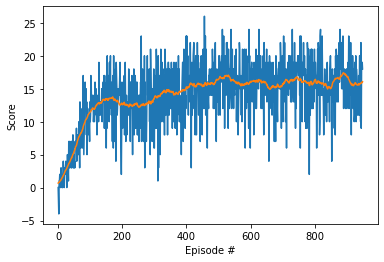

In [23]:
# plot the best scores
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

fig = plt.figure()
ax = fig.add_subplot(111)
window = 50
plt.plot(np.arange(len(scores)-window), scores[:-window])
plt.plot(np.arange(len(scores)-window), movingaverage(scores,window)[:-window])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Watch the agent collecting bananas :)

In [8]:
# load the weights from file
agent = DqnAgent(id=6, state_size=37, action_size=4, seed=0, use_double=True, use_prio=False, use_dueling=True)
agent.qnetwork_local.load_state_dict(torch.load('dueling_double_dqn.pth'))

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]            # get the current state
score = 0 

while True:
    action = agent.act(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
          
print('Score: {}'.format(score))
env.close()

Score: 14.0
